In [22]:
%load_ext autoreload
%autoreload 2
import os
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
from SRtools import readResultsBaysian as rrb
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
import emcee
import numpy as np
from SRtools import SR_hetro as srh
from SRtools import presets
import matplotlib.pyplot as plt
from SRtools import readResultsBaysian as rrb
from matplotlib import image as mpimg
from matplotlib import offsetbox
from SRtools import utils
from SRtools import plotting_utils as pu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
save_fig = False
filetype = 'pdf'
life_span_param ='best fit no ext hazard_MedianLifetime'

In [24]:
# Define multiple paths to load
paths = [

    'results/summery_mode.csv',
    # Add more paths here, for example:
    # 'results18/summery_mode.csv',
    # 'results19/summery_mode.csv',
]

# Define labels for each path (for legend)
path_labels = [

    'ref',
    # Add corresponding labels here:
    # 'results18',
    # 'results19',
]

In [25]:
columns = ['mice_F','mice_M','yeast','ecoli','cats_vp_M', 'cats_vp_F',
        'drosophila_853','drosophila_707','drosophila_441','drosophila_217',
        #'Sweden_M_1910_hetro','Sweden_F_1910_hetro','Denmark_M_1900_hetro','Denmark_M_1890_hetro',
        'Staffy_vetCompass','Labradors_vetCompass','Jack_Russell_vetCompass','German_Shepherd_vetCompass',
        #'Denmark_F_1890_hetro', 'Denmark_F_1900_hetro',
        'celegans','Guiniea_pig_VC','combined_human_F','combined_human_M']



# Load data from all paths
all_data = []
for path in paths:
    values_by_param, ci_by_param, selected_value_columns = utils.read_summary_csv(path, columns=columns)
    all_data.append({
        'values_by_param': values_by_param,
        'ci_by_param': ci_by_param,
        'selected_value_columns': selected_value_columns
    })

# Keep the first dataset for compatibility with existing code
values_by_param = all_data[0]['values_by_param']
ci_by_param = all_data[0]['ci_by_param']
selected_value_columns = all_data[0]['selected_value_columns']
# sil = utils.get_summery_csv_df(columns=columns)

In [26]:
print(values_by_param.keys())

dict_keys(['xc/eta', 'beta/eta', 'xc^2/epsilon', 'xc', 'eta', 'beta', 'epsilon', 'sqrt(xc/eta)', 's= eta^0.5*xc^1.5/epsilon', 'beta*xc/epsilon', 'eta*xc/epsilon', 'Fx=beta^2/eta*xc', 'Dx =beta*epsilon/eta*xc^2', 'Pk=beta*k/epsilon', 'Fk=beta^2/eta*k', 'Dk =beta*epsilon/eta*k^2', 'Fk^2/Dk=beta^3/eta*epsilon', 'epsilon/beta^2', 'k/beta', 'k^2/epsilon', 'best fit no ext hazard_MedianLifetime', 'best fit no ext hazard_MaxLifetime', 'best fit_MedianLifetime', 'best fit_MaxLifetime', 'data_MedianLifetime', 'data_MaxLifetime', 'ML_lnprob', 'ExtH', 'eta/xc', 'beta/xc', 'epsilon/xc^2', 'k/xc'])


/var/folders/pr/hngn4yrn3v3gt3069stbsfqh0000gp/T/ipykernel_51471/3763021313.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_per_path = matplotlib.cm.get_cmap('tab10')(np.linspace(0, 1, n_paths))


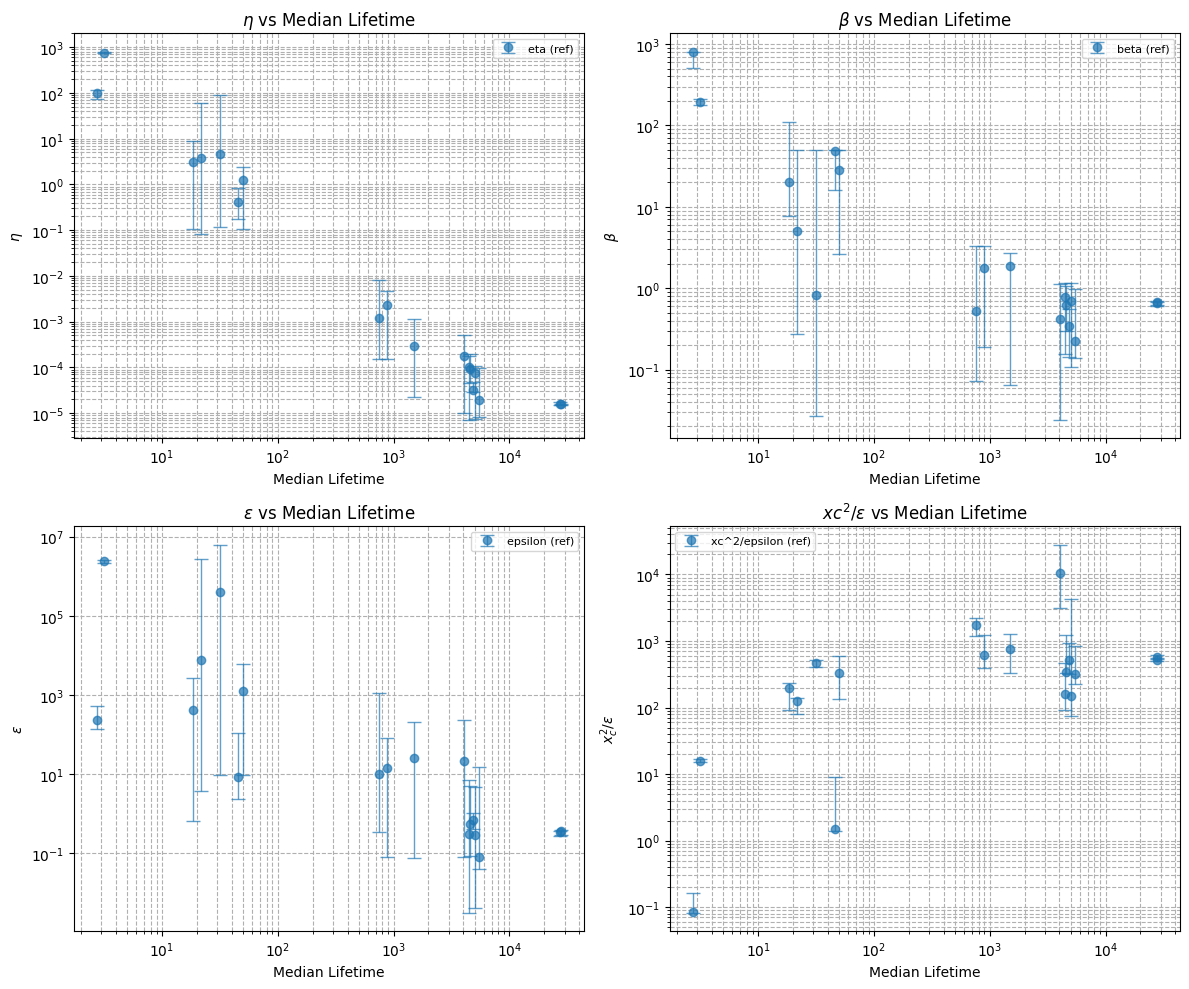

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define colors for each parameter (base colors)
param_colors = {
    "eta": "black",
    "beta": "#ffbb78",      # light orange (Matplotlib's default color palette)
    "epsilon": "blue",
    "xc^2/epsilon": "green"
}

# Define markers for each path
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', '<', '>']
# Define color shades/variations for each path (using colormap)
n_paths = len(paths)
colors_per_path = matplotlib.cm.get_cmap('tab10')(np.linspace(0, 1, n_paths))

# Helper function to plot on log-log with error bars, marker, and color
def plot_param_vs_ML(ax, param, param_ci, label, ylabel, color, marker='o', alpha=0.7):
    ml = np.array(param['ML'])
    p = np.array(param['values'])
    # Compute yerr from CI info, flexible to CI shape
    if param_ci is not None:
        if isinstance(param_ci, list) or isinstance(param_ci, tuple):
            param_ci = np.array(param_ci)
        if param_ci.shape[0] == 2 and param_ci.shape[1] == len(p):
            yerr = np.abs(param_ci - p)
        elif param_ci.shape == (len(p), 2):
            yerr = np.abs(param_ci.T - p)
        else:
            yerr = None
    else:
        yerr = None
    
    if yerr is not None:
        ax.errorbar(
            ml, p, 
            yerr=yerr, 
            fmt=marker, 
            capsize=5,
            elinewidth=1,
            markeredgewidth=1,
            linewidth=0,
            label=label,
            color=color,
            ecolor=color,
            alpha=alpha,
            markersize=6
        )
    else:
        ax.plot(ml, p, marker, label=label, color=color, alpha=alpha, markersize=6)
    ax.set_xlabel("Median Lifetime")
    ax.set_ylabel(ylabel)
    ax.grid(True, which="both", ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")

# Plot each parameter vs ML for all paths
for idx, (data, path_label) in enumerate(zip(all_data, path_labels)):
    values_by_param = data['values_by_param']
    ci_by_param = data['ci_by_param']
    
    ML = values_by_param[life_span_param]
    epsilon = values_by_param['epsilon']
    epsilon_ci = ci_by_param['epsilon']
    eta = values_by_param['eta']
    eta_ci = ci_by_param['eta']
    beta = values_by_param['beta']
    beta_ci = ci_by_param['beta']
    xc2ps = values_by_param['xc^2/epsilon']
    xc2eps_ci = ci_by_param['xc^2/epsilon']
    
    # Get marker and color for this path
    marker = markers[idx % len(markers)]
    # Use different colors per path (from colormap)
    path_color = colors_per_path[idx]
    alpha = 0.7
    
    # eta vs ML
    plot_param_vs_ML(axs[0,0], 
                     {'ML': ML, 'values': eta}, 
                     eta_ci, 
                     f"eta ({path_label})", 
                     r'$\eta$', 
                     path_color, 
                     marker=marker, 
                     alpha=alpha)
    
    # beta vs ML
    plot_param_vs_ML(axs[0,1], 
                     {'ML': ML, 'values': beta}, 
                     beta_ci, 
                     f"beta ({path_label})", 
                     r'$\beta$', 
                     path_color, 
                     marker=marker, 
                     alpha=alpha)
    
    # epsilon vs ML
    plot_param_vs_ML(axs[1,0], 
                     {'ML': ML, 'values': epsilon}, 
                     epsilon_ci, 
                     f"epsilon ({path_label})", 
                     r'$\epsilon$', 
                     path_color, 
                     marker=marker, 
                     alpha=alpha)
    
    # x_c vs ML
    plot_param_vs_ML(axs[1,1], 
                     {'ML': ML, 'values': xc2ps}, 
                     xc2eps_ci, 
                     f"xc^2/epsilon ({path_label})", 
                     r'$x_c^2/\epsilon$', 
                     path_color, 
                     marker=marker, 
                     alpha=alpha)

# Set titles
axs[0,0].set_title(r'$\eta$ vs Median Lifetime')
axs[0,1].set_title(r'$\beta$ vs Median Lifetime')
axs[1,0].set_title(r'$\epsilon$ vs Median Lifetime')
axs[1,1].set_title(r'$xc^2/\epsilon$ vs Median Lifetime')

# Add legends
for ax in axs.flat:
    ax.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()


Plotting 23 parameters vs best fit no ext hazard_MedianLifetime


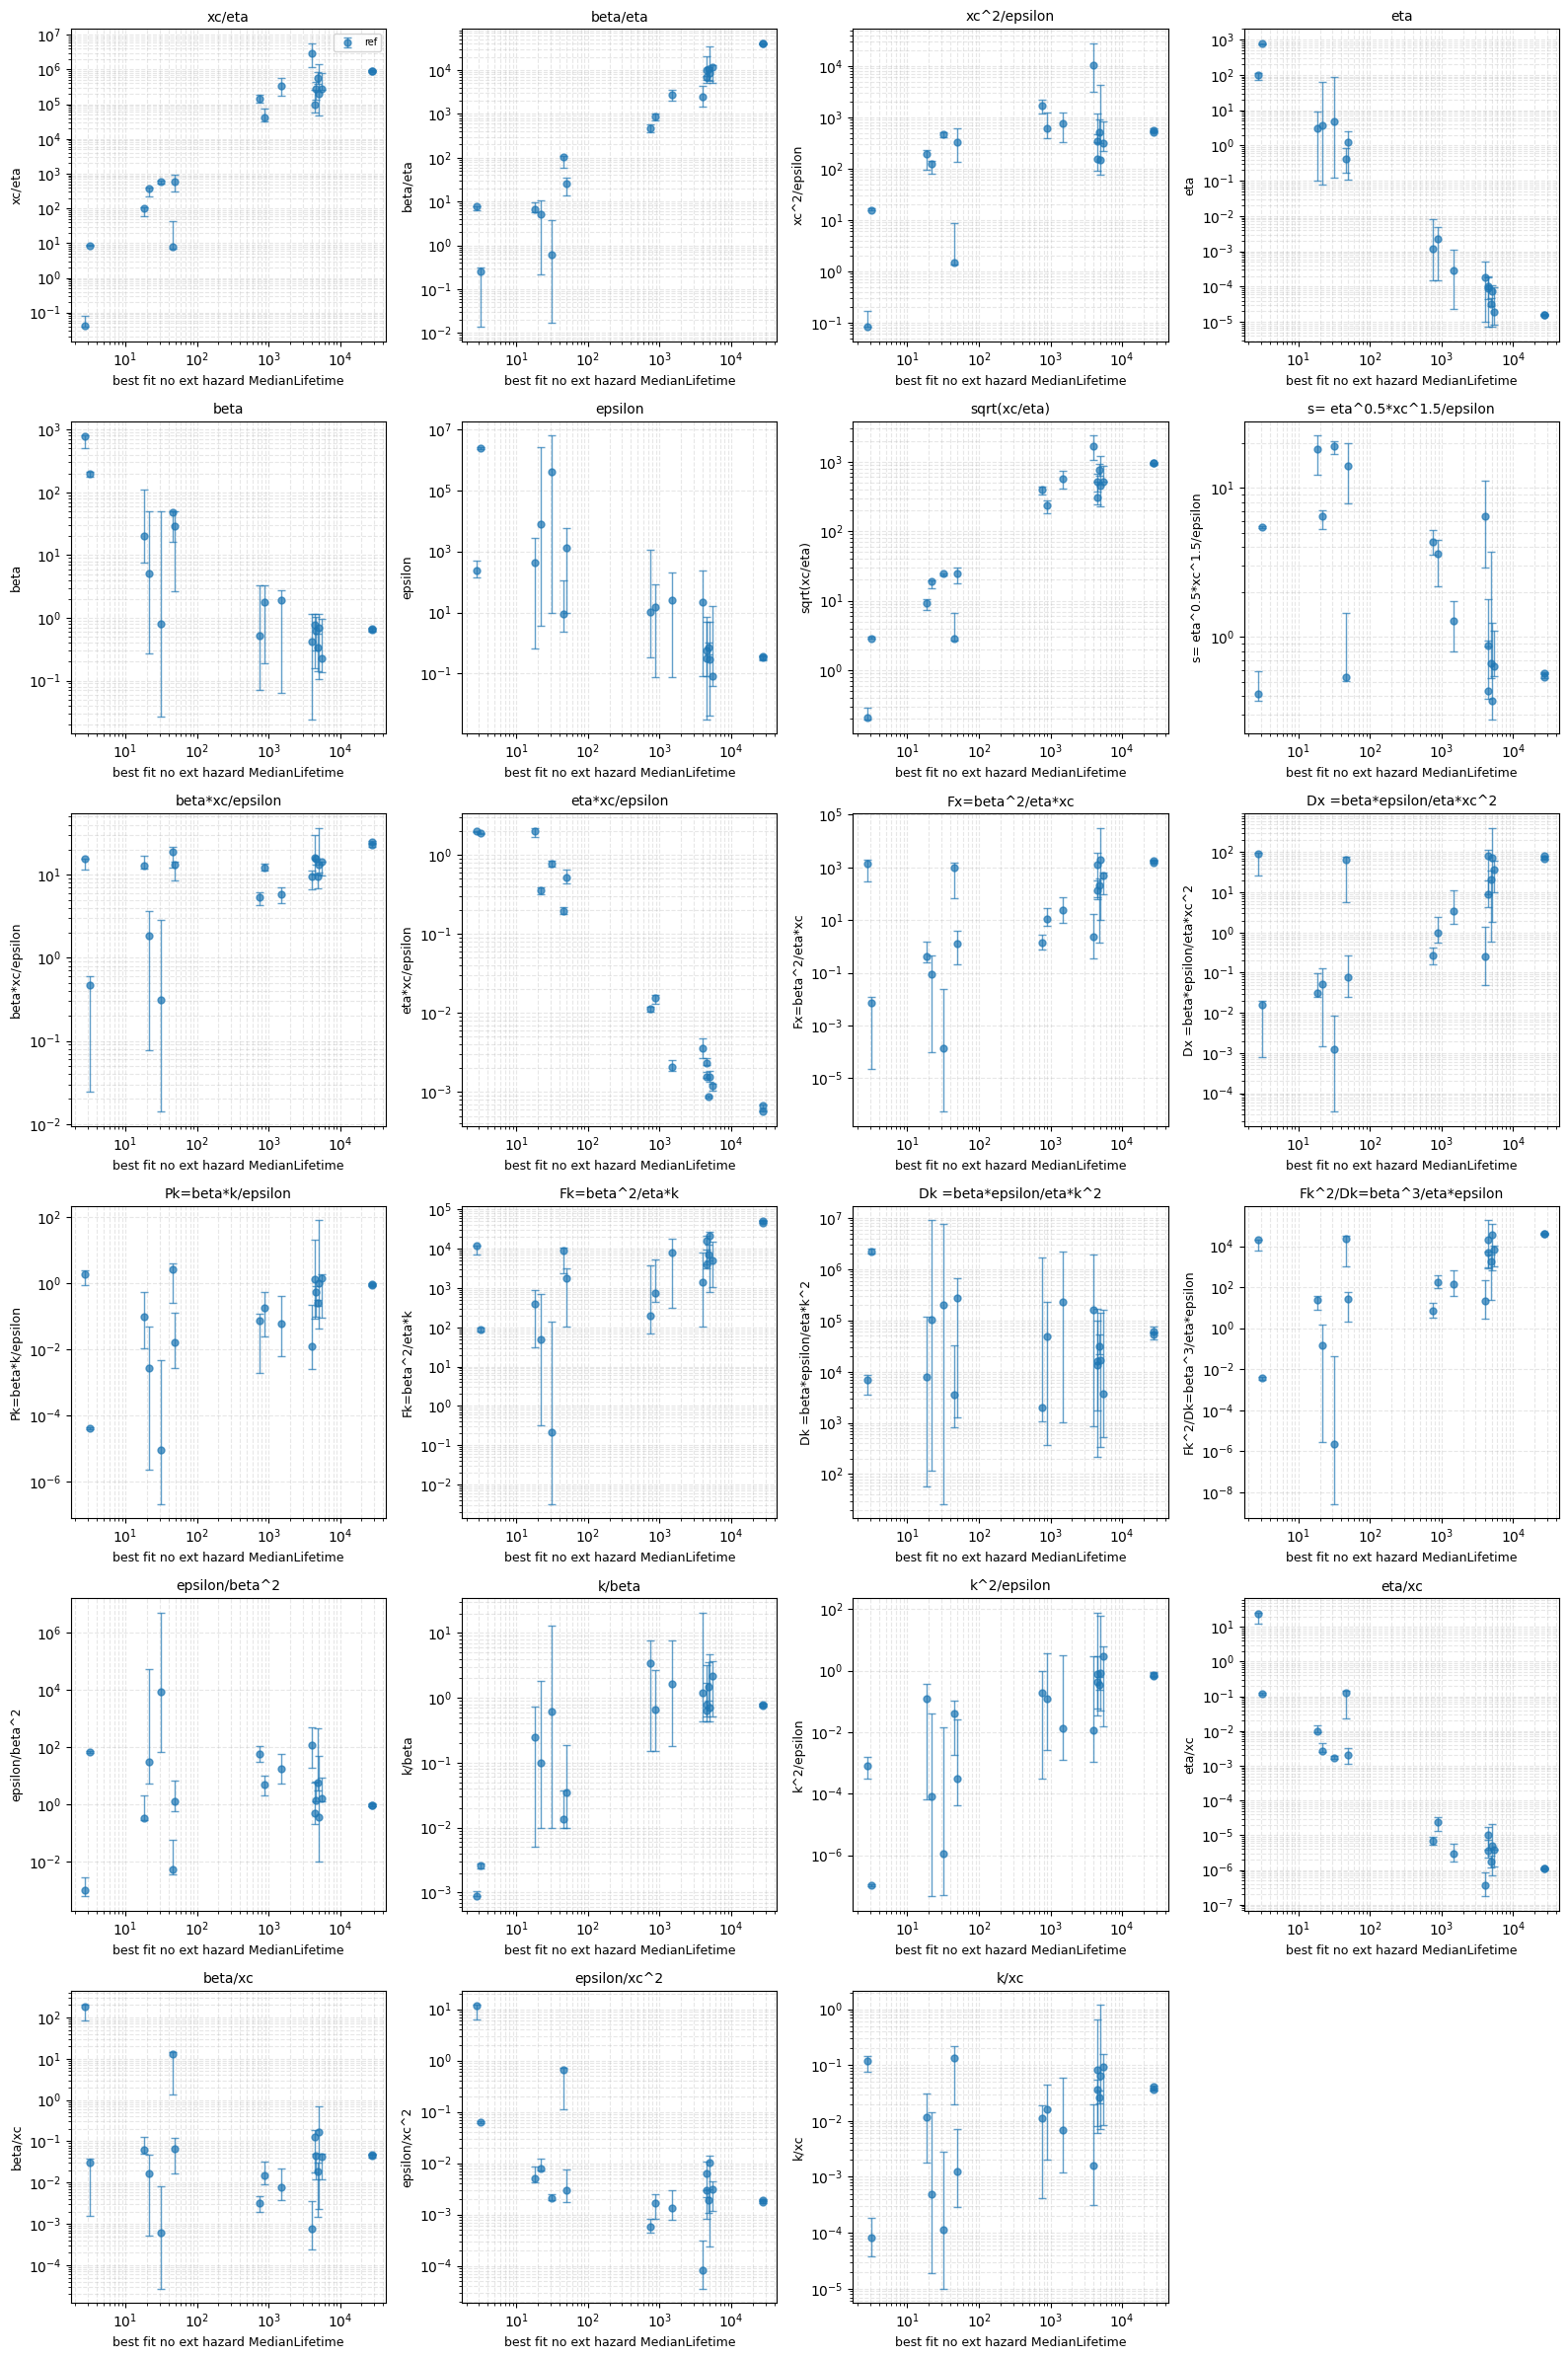

In [29]:
# Plot all parameters vs life_span_param (defaults to ML)


# Get all parameter keys from values_by_param
all_param_keys = list(values_by_param.keys())

# Filter out parameters that might not be suitable for this type of plot
# Exclude lifetime parameters and ML_lnprob to avoid redundancy
excluded_params = ['data_MedianLifetime', 'data_MaxLifetime', 'best fit_MedianLifetime', 
                   'best fit_MaxLifetime', 'best fit no ext hazard_MedianLifetime', 
                   'best fit no ext hazard_MaxLifetime', 'ML_lnprob','xc','ExtH']

filtered_params = []
for key in all_param_keys:
    if key not in excluded_params:
        try:
            param_values = values_by_param[key]
            param_ci = ci_by_param.get(key, None)
            if isinstance(param_values, (list, np.ndarray)) and len(param_values) == len(columns):
                filtered_params.append(key)
        except:
            pass

print(f"Plotting {len(filtered_params)} parameters vs {life_span_param}")

# Calculate grid dimensions for subplots
n_params = len(filtered_params)
n_cols = 4  # 4 columns per row
n_rows = int(np.ceil(n_params / n_cols))

# Create figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
if n_rows == 1:
    axs = axs.reshape(1, -1)
axs = axs.flatten()

# Define markers and colors for paths
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', '<', '>']
n_paths = len(paths)
colors_per_path = matplotlib.colormaps['tab10'](np.linspace(0, 1, n_paths))

# Helper function to plot on log-log with error bars
def plot_param_vs_lifespan(ax, ml, param_values, param_ci, label, ylabel, color, marker='o', alpha=0.7):
    p = np.array(param_values)
    # Compute yerr from CI info, flexible to CI shape
    if param_ci is not None:
        if isinstance(param_ci, list) or isinstance(param_ci, tuple):
            param_ci = np.array(param_ci)
        if param_ci.shape[0] == 2 and param_ci.shape[1] == len(p):
            yerr = np.abs(param_ci - p)
        elif param_ci.shape == (len(p), 2):
            yerr = np.abs(param_ci.T - p)
        else:
            yerr = None
    else:
        yerr = None
    
    if yerr is not None:
        ax.errorbar(
            ml, p, 
            yerr=yerr, 
            fmt=marker, 
            capsize=3,
            elinewidth=1,
            markeredgewidth=1,
            linewidth=0,
            label=label,
            color=color,
            ecolor=color,
            alpha=alpha,
            markersize=5
        )
    else:
        ax.plot(ml, p, marker, label=label, color=color, alpha=alpha, markersize=5)
    ax.set_xlabel(life_span_param.replace('_', ' '), fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.grid(True, which="both", ls="--", alpha=0.3)
    ax.set_xscale("log")
    ax.set_yscale("log")

# Plot each parameter vs life_span_param for all paths
for param_idx, param_key in enumerate(filtered_params):
    ax = axs[param_idx]
    
    for path_idx, (data, path_label) in enumerate(zip(all_data, path_labels)):
        values_by_param_path = data['values_by_param']
        ci_by_param_path = data['ci_by_param']
        # Check for negative values in param_values and ML, print the key if found
        if np.any(np.array(values_by_param_path[life_span_param]) < 0):
            print(f"Negative values found in {life_span_param} for path '{path_label}'")
        if np.any(np.array(values_by_param_path[param_key]) < 0):
            print(f"Negative values found in {param_key} for path '{path_label}'")
        
        ML = values_by_param_path[life_span_param]
        param_values = values_by_param_path[param_key]
        param_ci = ci_by_param_path.get(param_key, None)
        
        # Get marker and color for this path
        marker = markers[path_idx % len(markers)]
        path_color = colors_per_path[path_idx]
        alpha = 0.7
        
        # Plot parameter vs ML
        plot_param_vs_lifespan(ax, ML, param_values, param_ci, 
                              f"{path_label}", param_key, 
                              path_color, marker=marker, alpha=alpha)
    
    ax.set_title(param_key, fontsize=10)
    if param_idx == 0:  # Only show legend on first plot
        ax.legend(loc='best', fontsize=7)

# Hide unused subplots
for idx in range(n_params, len(axs)):
    axs[idx].axis('off')

plt.tight_layout()
if save_fig:
    plt.savefig(f'all_params_vs_{life_span_param}.{filetype}', dpi=300, bbox_inches='tight')
plt.show()
